In [ ]:
import sys
if not '../..' in sys.path:
    sys.path.append('../..')
    sys.path.append('..')
from analysis import collection, analysis, emg, plot, model
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import patches, lines
from pathlib import Path
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from joblib import dump, load
from analysis.offsets import offsets
import pickle

mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update({'axes.labelsize': 16})
mpl.rcParams.update({'figure.figsize': (16*0.8,9*0.8)})
mpl.rcParams.update({'axes.facecolor': "white"})
mpl.rcParams.update({'lines.marker': "+"})
mpl.rcParams.update({'lines.linestyle': ""})
mpl.rcParams.update({"axes.spines.left":   True})
mpl.rcParams.update({"axes.spines.bottom": True})
mpl.rcParams.update({"axes.spines.top":    False})
mpl.rcParams.update({"axes.spines.right":  False})

image_path = Path("/Users/spencer/phd/phd/images/more_results/nullspace/")

%matplotlib inline

Our hypothesis here is that if we optimize to find solutions in emg space which reach a chosen target while also minimizing a chosen function, e.g. distance of that solution to a statistical model, we can compare the distances between each of these solutions to the solutions subjects actually found in the task to suggest what subjects were optimizing for across learning.

## load data

this filtered data is NOT log-transformed

In [ ]:
with open('../olympics_subjects.pkl', 'rb') as handle:
    subjects = pickle.load(handle)
print(len(subjects))

subject_calibration_stacks = np.load("../subject_filtered_calibration_stacks.npy")
print(subject_calibration_stacks.shape)

subject_movement_stacks = np.load("../subject_filtered_movement_stacks.npy")
print(subject_movement_stacks.shape)

46
(46, 2, 32, 64, 2400)
(46, 2, 14, 64, 2000)


### experimental mixture model distances

In [ ]:
# def mixture_likelihood(model, x):
#     sum = 0
#     for mu, W, weight in zip(model.means_, model.covariances_, model.weights_):
#         logN = -1*(((x-mu).T @ np.linalg.inv(W) @ (x-mu)).reshape(-1)[0] + np.log(np.linalg.det(W)))
#         logw = np.log(weight)
#         sum += np.exp(logN + logw)
#     return sum

# def tipping_metric(model, xi, xj):
#     # generalization of the mahalanobis distance
#     # using a heuristic metric G(x) = sum_1^K { p(k|x) C_k^-1}
#     # a component-probability-weighted average of each mixture component's
#     # metric (inverse convariance)
#     # cf. "DERIVING CLUSTER ANALYTIC DISTANCE
#     #      FUNCTIONS FROM GAUSSIAN MIXTURE MODELS" 1999, Mike Tipping
#     means = model.means_
#     weights = model.weights_
#     Cinvs = [np.linalg.inv(C) for C in model.covariances_]
#     def integral(k):
#         v = (xi - xj).reshape(-1,1)
#         u = (means[k].reshape(-1,1) - xj).reshape(-1,1)
#         b2 = ((v.T @ Cinvs[k] @ v).reshape(-1)[0])**-1
#         a = b2*((v.T @ Cinvs[k] @ u).reshape(-1)[0])
#         e1 = (1 - a) / np.sqrt(2*b2)
#         e2 = (-a) / np.sqrt(2*b2)
#         Z = (u.T @ Cinvs[k] @ u).reshape(-1)[0] - b2*((v.T @ Cinvs[k] @ u).reshape(-1)[0]**2)
#         return np.sqrt(np.pi*b2*0.5)*(np.exp(-Z*0.5))*(sp.special.erf(e1) - sp.special.erf(e2))
#     integrals = [integral(k) for k in range(len(means))]
#     numerator = sum([np.linalg.inv(C_k)*pi_k*integral_k for C_k, pi_k, integral_k in zip(Cinvs,weights,integrals)])
#     denominator = sum([pi_k*integral_k for pi_k,integral_k in zip(weights,integrals)])
#     G = numerator / denominator
#     return G

# def tipping_distance(G, xi, xj):
#     d = xi - xj
#     return (d.T @ G @ d).reshape(-1)[0]
    
# def min_tipping_distance(model, x):
#     min_d = np.inf
#     min_G = None
#     for u,w in zip(model.means_,model.weights_):
#         G = tipping_metric(model,x,u.reshape(-1,1))
#         d = tipping_distance(G,x,u.reshape(-1,1))*w
#         if d < min_d:
#             min_d = d
#             min_G = G
#         return min_d, min_G

# def min_model_distance(model,x):
#     def quadratic(A,x):
#         return (x.T @ A @ x).reshape(-1)[0]
#     Cinvs = [np.linalg.inv(C) for C in model.covariances_]
#     return np.mean([quadratic(Cinvs[k],x-model.means_[k].reshape(-1,1))*model.weights_[k] for k in range(len(Cinvs))])


## optimization functions for scipy.optimize

In [ ]:
from scipy.optimize import minimize

# https://people.duke.edu/~ccc14/sta-663-2018/notebooks/S09H_Constrained_Optimization.html

def lagrange_fit(W,mu,D,x,e0=None,nonnegative=False):

    def f(e, W, mu):
        return ((e - mu).T @ W @ (e - mu)).reshape(-1)[0]
        # return (e.T) @ (W + np.eye(64)) @ (e) - + mu.T @ mu
        # return e.T @ W @ e + (e - mu).T @ (e - mu)
    
    def target_constraint(e):
        return D @ e - x
    
    def nonnegative_constraint(e):
        return e
    
    if nonnegative:
        cons = ({'type': 'eq', 'fun': target_constraint},
                {'type': 'ineq', 'fun': nonnegative_constraint})
    else:
        cons = ({'type': 'eq', 'fun': target_constraint})
                
    if e0 is None:
        e0 = np.zeros(shape=(64,))
    
    res = minimize(f, e0, constraints=cons, args=(W,mu))
    
    return res.x

def lagrange_fit_model_no_log(model,D,x,e0=None,nonnegative=False):

    def f(e, model):
        return -model.score(e.reshape(1,-1))
    
    def target_constraint(e):
        return D @ e - x
    
    def nonnegative_constraint(e):
        return e

    if nonnegative:
        cons = ({'type': 'eq', 'fun': target_constraint},
                {'type': 'ineq', 'fun': nonnegative_constraint})
    else:
        cons = ({'type': 'eq', 'fun': target_constraint})
    
    if e0 is None:
        e0 = np.zeros(shape=(64,))
    
    res = minimize(f, e0, constraints=cons, args=(model))
    
    return res.x

def lagrange_fit_model(model,D,x,e0=None,nonnegative=False):

    def f(e, model):
        return -model.score(np.log(e.reshape(1,-1)))
    
    def target_constraint(e):
        return D @ e - x
    
    def nonnegative_constraint(e):
        return e

    if nonnegative:
        cons = ({'type': 'eq', 'fun': target_constraint},
                {'type': 'ineq', 'fun': nonnegative_constraint})
    else:
        cons = ({'type': 'eq', 'fun': target_constraint})
    
    if e0 is None:
        e0 = np.zeros(shape=(64,)) + 0.01

    res = minimize(f, e0, constraints=cons, args=(model), bounds=[(1e-9,20.0) for _ in range(e0.shape[0])], options={"disp":False})
    
    return res.x

## visualize optimization in 2D

In [ ]:
# g1 = np.random.multivariate_normal(mean=[3,3],cov=[[.1,-.1],[-.1,1]],size=(500))
# g2 = np.random.multivariate_normal(mean=[-15,-15],cov=[[1.,0],[0,1]],size=(500))
# g3 = np.random.multivariate_normal(mean=[-3,3],cov=[[1,0],[0,1]],size=(500))
# g4 = np.random.multivariate_normal(mean=[3,-3],cov=[[1,0],[0,1]],size=(50))
# g5 = np.random.multivariate_normal(mean=[8,-7],cov=[[1,0],[0,1]],size=(500))
# samples = np.concatenate([g1,g2,g3,g4,g5])

# model = BayesianGaussianMixture(n_components=5)
# model.fit(samples)
# evals, evecs = np.linalg.eig(model.covariances_)

# # # for mi, mean in enumerate(model.means_):
# # #     plt.plot(mean[0],mean[1],"ro",alpha=1,markersize=20*model.weights_[mi])
# # #     plt.plot([mean[0], mean[0] + evals[mi][0]*evecs[mi][0][0]], [mean[1], mean[1] + evals[mi][0]*evecs[mi][1][0]],"r-")
# # #     plt.plot([mean[0], mean[0] + evals[mi][1]*evecs[mi][0][1]], [mean[1], mean[1] + evals[mi][1]*evecs[mi][1][1]],"r-")

# # plt.figure()
# # # plt.plot(samples[::3,0],samples[::3,1],'ko',markerfacecolor="None",alpha=0.4)
# # plt.xlim(-20,20)
# # plt.ylim(-20,20)
# # for mi, mean in enumerate(model.means_):
# #     plt.plot(mean[0],mean[1],"ro",alpha=1,markersize=20*model.weights_[mi])
# #     plt.plot([mean[0], mean[0] + evals[mi][0]*evecs[mi][0][0]], [mean[1], mean[1] + evals[mi][0]*evecs[mi][1][0]],"r-")
# #     plt.plot([mean[0], mean[0] + evals[mi][1]*evecs[mi][0][1]], [mean[1], mean[1] + evals[mi][1]*evecs[mi][1][1]],"r-")
# # N = 100
# # grand_mean = np.mean(model.means_,axis=0)
# # plt.plot(grand_mean[0],grand_mean[1],"g*")
# # distances = np.zeros(shape=(N,N))
# # xmin, xmax, ymin, ymax = -20,20,-20,20
# # for xi, x in enumerate(np.linspace(xmin,xmax,N)):
# #     for yi, y in enumerate(np.linspace(ymin,ymax,N)):
# #         distances[xi,yi] = mixture_likelihood(model, np.array([x,y]).reshape(-1,1))
# # plt.imshow(distances.T, origin='lower',extent=[xmin, xmax, ymin, ymax])
# # plt.colorbar()

# plt.figure()
# # plt.plot(samples[::3,0],samples[::3,1],'ko',markerfacecolor="None",alpha=0.4)
# plt.xlim(-20,20)
# plt.ylim(-20,20)
# for mi, mean in enumerate(model.means_):
#     plt.plot(mean[0],mean[1],"ro",alpha=1,markersize=20*model.weights_[mi])
#     plt.plot([mean[0], mean[0] + evals[mi][0]*evecs[mi][0][0]], [mean[1], mean[1] + evals[mi][0]*evecs[mi][1][0]],"r-")
#     plt.plot([mean[0], mean[0] + evals[mi][1]*evecs[mi][0][1]], [mean[1], mean[1] + evals[mi][1]*evecs[mi][1][1]],"r-")
# N = 100
# distances = np.zeros(shape=(N,N))
# xmin, xmax, ymin, ymax = -20,20,-20,20
# for xi, x in enumerate(np.linspace(xmin,xmax,N)):
#     for yi, y in enumerate(np.linspace(ymin,ymax,N)):
#         distances[xi,yi] = -model.score(np.array([x,y]).reshape(1,-1))
# plt.imshow(distances.T, origin='lower',extent=[xmin, xmax, ymin, ymax])
# plt.colorbar()


# # test_decoder = subjects[5].decoder[-2:,:]
# # test_cov = compute_prior_cov(5)

# # # fig, loss_ax = plt.subplots(1,1,figsize=(10,10))
# # fig, target_ax = plt.subplots(1,1,figsize=(10,10))
# # fig, emg_ax = plt.subplots(1,1,figsize=(10,10))

# # W = np.eye(64)
# # mu = np.zeros(shape=(64,))
# # for i in range(1,13):
# #     target_vec = collection.compute_target_vec_from_number(i).reshape(2,1)
# #     target_ax.plot(target_vec[0], target_vec[1], "ro")
# #     numpy_e = np.linalg.pinv(test_decoder) @ target_vec
# #     emg_ax.plot(numpy_e, "b--", alpha=0.5)

# #     e_lagrange = lagrange_fit(W,mu,test_decoder,target_vec.reshape(-1))
# #     emg_ax.plot(e_lagrange, "r--", alpha=0.5)
# #     lag_t = test_decoder @ e_lagrange
# #     target_ax.plot(lag_t[0], lag_t[1], "ro")

# #     e_lagrange = lagrange_fit(test_cov,mu,test_decoder,target_vec.reshape(-1))
# #     emg_ax.plot(e_lagrange, "k", alpha=0.5)
# #     lag_t = test_decoder @ e_lagrange
# #     target_ax.plot(lag_t[0], lag_t[1], "ko")


In [ ]:
# plot.save_figure(cost_function_fig, "example_cost_functions",image_path)

# get hit ends for all subjects

In [ ]:
NUM_ENDPOINTS = 3
hit_ends = np.zeros(shape=(46,45,12,64))
hit_ends[:] = np.nan
for subject_idx, subject in enumerate(subjects):
    target_counter = np.zeros(shape=(12),dtype=int)
    for session in list(subject.tasks["center_hold"].sorted_sessions()):
        for trial in session.sorted_trials():
            if trial.outcome == "Hit":
                hit_end = np.mean(trial.get_filtered_emg()[-NUM_ENDPOINTS:,:], axis=0)
                hit_ends[subject_idx,target_counter[trial.target_number-1],trial.target_number-1] = hit_end
                target_counter[trial.target_number-1] += 1

hit_end_means = np.nanmean(hit_ends, axis=(1))
print(hit_ends.shape, hit_end_means.shape)

(46, 45, 12, 64) (46, 12, 64)


### visualize hit ends, prior means, model means for one subject

In [ ]:
def compute_movement_cov(subject_idx):
    calibration = analysis.remove_nan_rows(subject_calibration_stacks[subject_idx].transpose(0,1,3,2).reshape(-1,64))
    return np.cov(calibration.T)

def compute_movement_mean(subject_idx):
    calibration = analysis.remove_nan_rows(subject_calibration_stacks[subject_idx].transpose(0,1,3,2).reshape(-1,64))
    return np.nanmean(calibration.T,axis=1)

def compute_calibration_cov(subject_idx):
    movement = analysis.remove_nan_rows(subject_movement_stacks[subject_idx].transpose(0,1,3,2).reshape(-1,64))
    return np.cov(movement.T)

def compute_calibration_mean(subject_idx):
    movement = analysis.remove_nan_rows(subject_movement_stacks[subject_idx].transpose(0,1,3,2).reshape(-1,64))
    return np.nanmean(movement.T,axis=1)

Text(0, 0.5, 'EMG Activity')

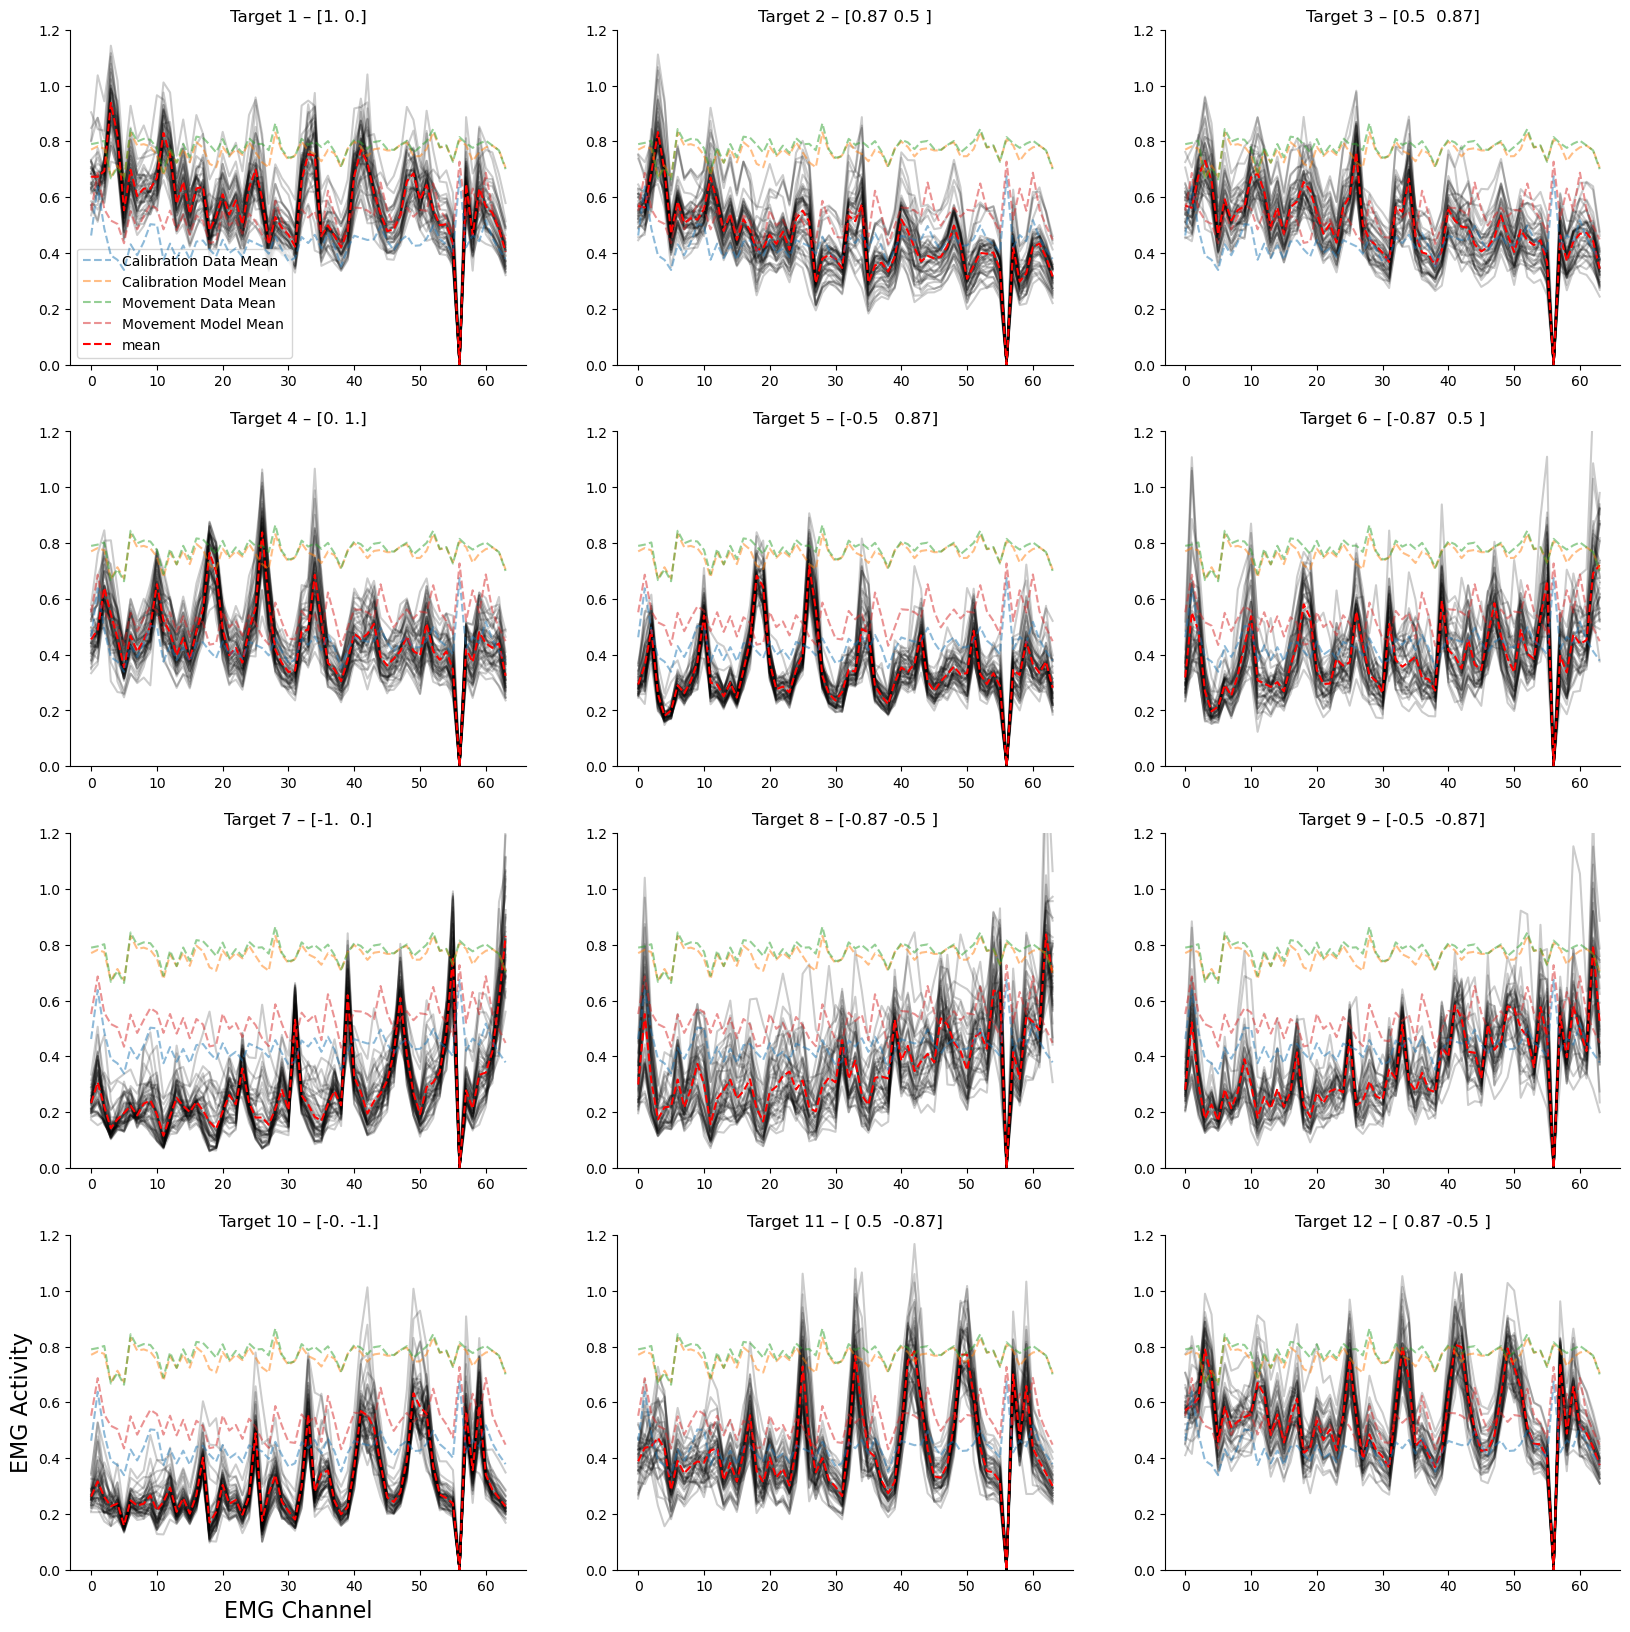

In [ ]:
fig, axes = plt.subplots(4,3,figsize=(20,20))
axes = axes.ravel()

subject_idx = 6

movement_model = model.load_log_movement_models(subject_idx)[0]
calibration_model = model.load_log_calibration_models(subject_idx)[0]

movement_model_mean = np.mean([model.make_lognormal_mean(m.reshape(-1,1),c).reshape(-1) for m,c in zip(movement_model.means_, movement_model.covariances_)],axis=0)
calibration_model_mean = np.mean([model.make_lognormal_mean(m.reshape(-1,1),c).reshape(-1) for m,c in zip(calibration_model.means_, calibration_model.covariances_)],axis=0)

movement_data_mean = compute_movement_mean(subject_idx)
calibration_data_mean = compute_calibration_mean(subject_idx)

for target_idx in range(12):
    axes[target_idx].plot(calibration_data_mean,"--",alpha=0.5,zorder=100,label="Calibration Data Mean")
    axes[target_idx].plot(calibration_model_mean,"--",alpha=0.5,zorder=100,label="Calibration Model Mean")
    axes[target_idx].plot(movement_data_mean,"--",alpha=0.5,zorder=100,label="Movement Data Mean")
    axes[target_idx].plot(movement_model_mean,"--",alpha=0.5,zorder=100,label="Movement Model Mean")
    subject_target_ends = analysis.remove_nan_rows(hit_ends[subject_idx,:,target_idx])
    for end in subject_target_ends:
        axes[target_idx].plot(end,"k",alpha=0.2,linestyle="-",marker="")
    axes[target_idx].plot(hit_end_means[subject_idx,target_idx],"r--",label="mean")
    axes[target_idx].set_title(f"Target {target_idx+1} – {collection.compute_target_vec_from_number(target_idx+1)}")
    axes[target_idx].set_ylim([0,1.2])
axes[0].legend()
axes[9].set_xlabel("EMG Channel")
axes[9].set_ylabel("EMG Activity")

# compute solutions

In [ ]:
# check if subject's channel 56 is dead
tol = 1e-7
for subject_idx in range(46):
    for target_idx in range(12):
        mean56 = np.mean(analysis.remove_nan_rows(hit_ends[subject_idx,:,target_idx])[:,56])
        if not np.isclose(mean56, 0, rtol=tol):
            print(subject_idx, target_idx, mean56)

In [ ]:
from analysis.model import *

In [ ]:
import warnings
warnings.filterwarnings("ignore", message="Values in x were outside bounds during a minimize step, clipping to bounds")

In [ ]:
# subject, solution type, target, channel
computed_solutions = np.zeros(shape=(46,10,12,64))
computed_solutions[:] = np.nan
for subject_idx in range(len(subjects)):
    decoder = subjects[subject_idx].decoder[-2:,:]
    movement_cov = compute_movement_cov(subject_idx)
    movement_mean = compute_movement_mean(subject_idx)
    calibration_mean = compute_calibration_mean(subject_idx)
    calibration_cov = compute_calibration_cov(subject_idx)
    print(f"subject {subject_idx}")
    calibration_model = load_log_calibration_models(subject_idx)[0]
    movement_model = load_log_movement_models(subject_idx)[0]
    for target_idx in range(12):
        target_vec = collection.compute_target_vec_from_number(target_idx+1)
        # the "pinv" solution
        computed_solutions[subject_idx,0,target_idx] = lagrange_fit(np.eye(64),np.zeros(shape=(64,1)),decoder,target_vec.reshape(-1),nonnegative=True)

        # movement mean error
        computed_solutions[subject_idx,1,target_idx] = lagrange_fit(np.eye(64),movement_mean,decoder,target_vec.reshape(-1),nonnegative=True)

        # calibration mean error
        computed_solutions[subject_idx,2,target_idx] = lagrange_fit(np.eye(64),calibration_mean,decoder,target_vec.reshape(-1),nonnegative=True)

        # the "gaussian" likelihood with movement stats solution
        computed_solutions[subject_idx,3,target_idx] = lagrange_fit(np.linalg.inv(movement_cov),movement_mean,decoder,target_vec.reshape(-1),nonnegative=True)

        # the "gaussian" likelihood with calibration stats
        computed_solutions[subject_idx,4,target_idx] = lagrange_fit(np.linalg.inv(calibration_cov),calibration_mean,decoder,target_vec.reshape(-1),nonnegative=True)

        # the movement mixture likelihood solution nonnegative -- starting from gaussian solution
        computed_solutions[subject_idx,5,target_idx] = lagrange_fit_model(movement_model,decoder,target_vec.reshape(-1),e0=computed_solutions[subject_idx,3,target_idx],nonnegative=True)

        # the calibration mixture likelihood solution nonnegative -- starting from gaussian solution
        computed_solutions[subject_idx,6,target_idx] = lagrange_fit_model(calibration_model,decoder,target_vec.reshape(-1),e0=computed_solutions[subject_idx,4,target_idx],nonnegative=True)

labels = ["standard normal", 
          "movement mean",
          "calibration mean",
          "movement gaussian",
          "calibration gaussian",
          "movement likelihood",
          "calibration likelihood"]

subject 0
subject 1
subject 2
subject 3
subject 4
subject 5
subject 6
subject 7
subject 8
subject 9
subject 10
subject 11
subject 12
subject 13
subject 14
subject 15
subject 16
subject 17
subject 18
subject 19
subject 20
subject 21
subject 22
subject 23
subject 24
subject 25
subject 26
subject 27
subject 28
subject 29
subject 30
subject 31
subject 32
subject 33
subject 34
subject 35
subject 36
subject 37


In [ ]:
# with open('../../computed_solutions.pkl', 'wb') as handle:
#     pickle.dump(computed_solutions, handle)

In [ ]:
with open('../../computed_solutions.pkl', 'rb') as handle:
    computed_solutions = pickle.load(handle)
print(computed_solutions.shape)

(46, 10, 12, 64)
